In [37]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
import gc
import numpy as np

# Set memory fragmentation configuration
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:50'
gc.collect()
torch.cuda.empty_cache()

# Initialize tokenizer and model configuration to output hidden states
model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name, output_hidden_states=True)

try:
    model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to('cuda')
    print("Classification model loaded on CUDA")
except RuntimeError as e:
    print(f"RuntimeError: {e}")
    print("CUDA out of memory. Loading classification model on CPU instead.")
    model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to('cpu')

model.eval()  # Set the model to evaluation mode after loading, ensuring it is called for both try and except blocks
print('Hi')

Classification model loaded on CUDA
Hi


In [3]:
def model_predict(texts):
    """ Predicts class probabilities for given texts using the model. """
    predictions = []
    device = model.device
    for text in texts:
        # Ensure text is a string
        text = str(text)
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()  # Convert logits to probabilities
            probs = probs[:, [0, 2, 1]]  # Reorder to ["True", "False", "Not Enough Info"]
        predictions.append(probs)
    return np.array(predictions)

def get_embeddings(texts):
    """ Extract text embeddings from the last hidden state of the model. """
    embeddings = []
    with torch.no_grad():
        for text in texts:
            # Ensure text is a string
            text = str(text)
            inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
            outputs = model(**inputs)
            emb = outputs.hidden_states[-1].mean(dim=1).cpu().numpy()  # Get the last layer's hidden state
            embeddings.append(emb.flatten())
    return np.array(embeddings)

Model loaded on CUDA


In [4]:
import pandas as pd

# Load dataset
data_path = '/home/qsh5523/Documents/factver/Master.csv'
factver_data = pd.read_csv(data_path)

# Ensure that all text data is treated as string and handle any potential missing values
factver_data['Claim_text'] = factver_data['Claim_text'].astype(str)
factver_data['Evidence_text'] = factver_data['Evidence_text'].astype(str)

# If your dataset has any specific preprocessing needs, handle them here
# For example, you might want to fill missing values if any
factver_data.fillna('Missing Data', inplace=True)

# Group evidence texts by 'Claim_topic_id'
# Assuming each claim has a unique ID and multiple pieces of evidence
grouped_data = factver_data.groupby('Claim_topic_id').agg({
    'Claim_text': 'first',  # Use the first occurrence of claim text in each group
    'Evidence_text': lambda x: list(x),  # Collect all evidences related to each claim into a list
    'Label': 'first'  # Use the first label of each group, assuming label consistency within the group
}).reset_index()

# Display the first few rows to check your data
print(grouped_data.head())

           Claim_topic_id                                         Claim_text  \
0   Claims_Climate_B2.0_1            New Zealand has a carbon trading system   
1  Claims_Climate_B2.0_10  The EU Emission trading scheme aims to reduce ...   
2  Claims_Climate_B2.0_11             Agriculture is a small emission sector   
3  Claims_Climate_B2.0_12                     Agriculture is a large emitter   
4  Claims_Climate_B2.0_13  The EU is aiming to half shipping emissions by...   

                                       Evidence_text Label  
0  [A number of other countries have, however, al...     T  
1  [The European Union has decided not to wait fo...     T  
2  [Given that the agricultural sector accounts f...     F  
3  [But Robertson said the agricultural sector wa...     T  
4  [Looking ahead, shipping is set to be included...     N  


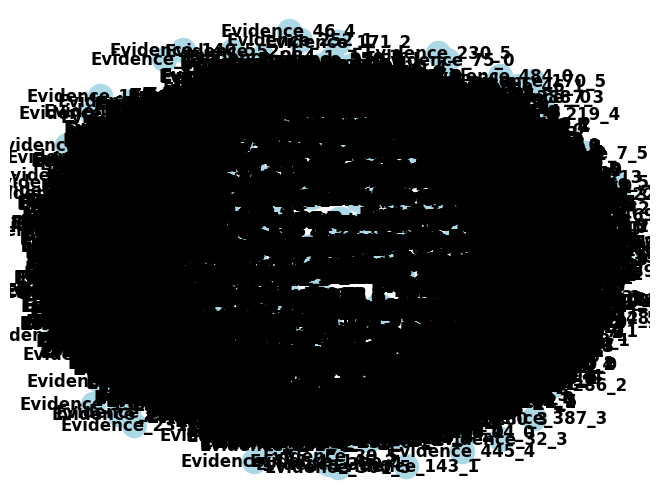

AttributeError: module 'networkx' has no attribute 'write_gpickle'

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pickle
# Create a graph
G = nx.Graph()

# Add nodes with embeddings
for index, row in grouped_data.iterrows():
    claim = str(row['Claim_text'])  # Ensure claim is a string
    evidences = row['Evidence_text']
    claim_embeddings = get_embeddings([claim])[0]  # Get the single embedding for the claim
    G.add_node(f"Claim_{index}", embedding=claim_embeddings, type='claim', text=claim)

    for i, evidence in enumerate(evidences):
        evidence = str(evidence)  # Ensure evidence is a string
        evidence_embeddings = get_embeddings([evidence])[0]  # Get the embedding for each evidence
        G.add_node(f"Evidence_{index}_{i}", embedding=evidence_embeddings, type='evidence', text=evidence)
        # Add edges with similarities as weights
        similarity = cosine_similarity(claim_embeddings.reshape(1, -1), evidence_embeddings.reshape(1, -1))[0][0]
        if similarity > 0.5:  # You can adjust this threshold
            G.add_edge(f"Claim_{index}", f"Evidence_{index}_{i}", weight=similarity)


# Save the graph
with open("evidence_graph.pkl", "wb") as f:
    pickle.dump(G, f)

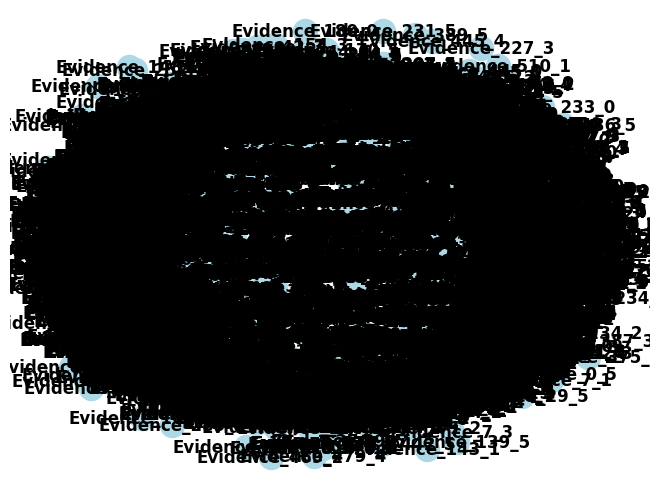

In [7]:
#matplotlib.use('module://ipykernel.pylab.backend_inline')
#print(matplotlib.get_backend())
# Optionally visualize the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='lightblue', edge_color='gray')
plt.show()

Number of nodes: 25
Number of edges: 13


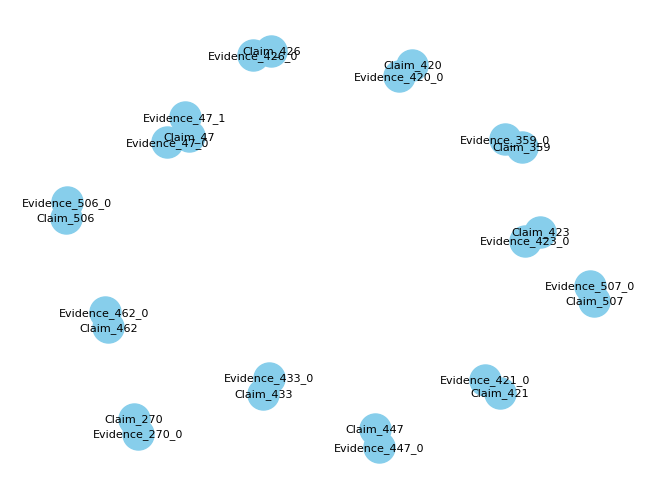

In [34]:


# Assuming G is your graph
# Further adjust node degree threshold
degree_threshold = 0  # Including all nodes regardless of degree
filtered_nodes = [node for node, degree in dict(G.degree()).items() if degree > degree_threshold]

# Create a subgraph from filtered nodes
preliminary_subgraph = G.subgraph(filtered_nodes)

# Further adjust edge weight threshold
weight_threshold = 0.97  # Including more edges by lowering the weight threshold
filtered_edges = [(u, v) for u, v, d in preliminary_subgraph.edges(data=True) if d['weight'] > weight_threshold]

# Create the final subgraph using the filtered edges
subgraph = preliminary_subgraph.edge_subgraph(filtered_edges)

# Print diagnostic information
print("Number of nodes:", len(subgraph.nodes))
print("Number of edges:", len(subgraph.edges))

# Draw the simplified graph if not empty
if len(subgraph.nodes) == 0 or len(subgraph.edges) == 0:
    print("Subgraph is still empty. Consider visualizing the original graph to understand its structure.")
else:
    pos = nx.spring_layout(subgraph)  # Positions for all nodes
    nx.draw(subgraph, pos, with_labels=True, node_color='skyblue', edge_color='#FF5733', node_size=500, font_size=8)
    plt.show()

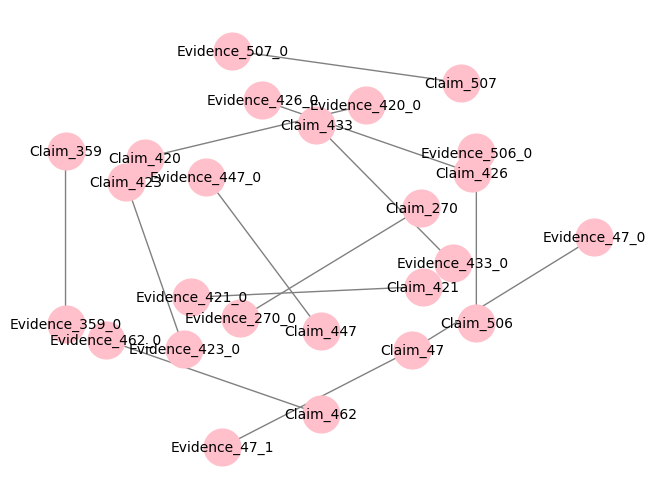

In [35]:
# Use different layout algorithms to find one that works best for visualization
pos = nx.kamada_kawai_layout(subgraph)  # Alternative layout
nx.draw(subgraph, pos, with_labels=True, node_color='pink', edge_color='gray', node_size=700, font_size=10)
plt.show()